In [1]:
# # this just to make sure we are using only on CPU
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
%matplotlib nbagg
import os.path as op
import time

from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import load_model, Model
from keras_tqdm import TQDMNotebookCallback
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from fastmri_recon.data.fastmri_sequences import Masked2DSequence, KIKISequence
from fastmri_recon.helpers.nn_mri import MultiplyScalar, lrelu
from fastmri_recon.helpers.utils import keras_psnr, keras_ssim
from fastmri_recon.models.kiki_sep import kiki_sep_net

/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['image.cmap'] = 'gray'

In [4]:
# paths
train_path = '/media/Zaccharie/UHRes/singlecoil_train/singlecoil_train/'
val_path = '/media/Zaccharie/UHRes/singlecoil_val/'
test_path = '/media/Zaccharie/UHRes/singlecoil_test/'

n_samples_train = 34742
n_samples_val = 7135

n_volumes_train = 973
n_volumes_val = 199


# generators
AF = 4
n_limit = 1
train_gen_last = Masked2DSequence(train_path, af=AF, inner_slices=8, rand=True, scale_factor=1e6)
train_gen_last.filenames = train_gen_last.filenames[:n_limit]
val_gen_last = Masked2DSequence(val_path, af=AF, scale_factor=1e6)
val_gen_last.filenames = val_gen_last.filenames[:1]
train_gen_i = KIKISequence(train_path, af=AF, inner_slices=8, rand=True, scale_factor=1e6, space='I')
train_gen_i.filenames = train_gen_i.filenames[:n_limit]
val_gen_i = KIKISequence(val_path, af=AF, scale_factor=1e6, space='I')
val_gen_i.filenames = val_gen_i.filenames[:1]
train_gen_k = KIKISequence(train_path, af=AF, inner_slices=8, rand=True, scale_factor=1e6, space='K')
train_gen_k.filenames = train_gen_k.filenames[:n_limit]
val_gen_k = KIKISequence(val_path, af=AF, scale_factor=1e6, space='K')
val_gen_k.filenames = val_gen_k.filenames[:1]

In [5]:
run_params = {
    'n_convs': 25,
    'n_filters': 48,
    'noiseless': True,
    'lr': 1e-3,
    'activation': lrelu,
}
multiply_scalar = MultiplyScalar()
n_epochs = 300

def train_model(model, space='K', n=1):
    print(model.summary(line_length=150))
    run_id = f'kikinet_sep_{space}{n}_af{AF}_{int(time.time())}'
    chkpt_path = f'checkpoints/{run_id}' + '-{epoch:02d}.hdf5'
    print(run_id)

    chkpt_cback = ModelCheckpoint(chkpt_path, period=50)
    log_dir = op.join('logs', run_id)
    tboard_cback = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_images=False,
    )
    tqdm_cb = TQDMNotebookCallback(metric_format="{name}: {value:e}")
    if space == 'K':
        train_gen = train_gen_k
        val_gen = val_gen_k
    elif space == 'I':
        if n == 2:
            train_gen = train_gen_last
            val_gen = val_gen_last
        elif n == 1:
            train_gen = train_gen_i
            val_gen = val_gen_i
    model.fit_generator(
        train_gen,
        steps_per_epoch=n_limit,
        epochs=n_epochs,
#         validation_data=val_gen,
#         validation_steps=1,
        verbose=2,
        callbacks=[tqdm_cb],
#         callbacks=[tqdm_cb, tboard_cback, chkpt_cback,],
#         max_queue_size=35,
#         use_multiprocessing=True,
#         workers=35,
        shuffle=False,
    )
    return model

In [6]:
# %%debug
model_1 = kiki_sep_net(None, multiply_scalar, to_add='K', last=False, **run_params)
# model_1.load_weights('../checkpoints/kikinet_sep_K1_af4_1569748407-30.hdf5')
# model_2 = kiki_sep_net(model_1, multiply_scalar, to_add='I', last=False, **run_params)
# model_3 = kiki_sep_net(model_2, multiply_scalar, to_add='K', last=False, **run_params)
# model_4 = kiki_sep_net(model_3, multiply_scalar, to_add='I', last=True, **run_params)
train_model(model_1, space='K', n=1)

Model: "model_1"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
kspace_input (InputLayer)                        (None, 640, None, 1)             0                                                                   
______________________________________________________________________________________________________________________________________________________
lambda_1 (Lambda)                                (None, 640, None, 1)             0                 kspace_input[0][0]                                
______________________________________________________________________________________________________________________________________________________
lambda_2 (Lambda)                                (None, 640, None, 1)        

W0930 15:42:32.742064 140693985502976 deprecation_wrapper.py:119] From /volatile/home/Zaccharie/workspace/keras/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/300


 - 3s - loss: 10.8629 - mean_squared_error: 679.1568 - keras_psnr: 51.4081 - keras_ssim: 0.9974
Epoch 2/300


 - 0s - loss: 10.6304 - mean_squared_error: 554.5381 - keras_psnr: 50.7249 - keras_ssim: 0.9967
Epoch 3/300


 - 0s - loss: 10.9783 - mean_squared_error: 741.1116 - keras_psnr: 51.5171 - keras_ssim: 0.9976
Epoch 4/300


 - 0s - loss: 10.5365 - mean_squared_error: 549.2847 - keras_psnr: 50.5129 - keras_ssim: 0.9967
Epoch 5/300


 - 0s - loss: 10.6299 - mean_squared_error: 554.5355 - keras_psnr: 50.7249 - keras_ssim: 0.9967
Epoch 6/300


 - 0s - loss: 10.9780 - mean_squared_error: 741.0934 - keras_psnr: 51.5172 - keras_ssim: 0.9976
Epoch 7/300


 - 0s - loss: 10.5420 - mean_squared_error: 727.4520 - keras_psnr: 51.9718 - keras_ssim: 0.9980
Epoch 8/300


 - 0s - loss: 9.9026 - mean_squared_error: 534.4870 - keras_psnr: 52.1798 - keras_ssim: 0.9979
Epoch 9/300


 - 0s - loss: 10.8628 - mean_squared_error: 679.1824 - keras_psnr: 51.4079 - keras_ssim: 0.9974
Epoch 10/300


 - 0s - loss: 10.4890 - mean_squared_error: 522.2294 - keras_psnr: 50.0652 - keras_ssim: 0.9964
Epoch 11/300


 - 0s - loss: 10.5363 - mean_squared_error: 549.1293 - keras_psnr: 50.5141 - keras_ssim: 0.9967
Epoch 12/300


 - 0s - loss: 10.9777 - mean_squared_error: 740.6478 - keras_psnr: 51.5198 - keras_ssim: 0.9976
Epoch 13/300


 - 0s - loss: 10.5023 - mean_squared_error: 571.3376 - keras_psnr: 51.0813 - keras_ssim: 0.9971
Epoch 14/300


 - 0s - loss: 10.4750 - mean_squared_error: 533.9930 - keras_psnr: 50.6355 - keras_ssim: 0.9968
Epoch 15/300


 - 0s - loss: 10.3770 - mean_squared_error: 476.7701 - keras_psnr: 51.3811 - keras_ssim: 0.9970
Epoch 16/300


 - 0s - loss: 14.0730 - mean_squared_error: 1694.8784 - keras_psnr: 47.9246 - keras_ssim: 0.9947
Epoch 17/300


 - 0s - loss: 16.6106 - mean_squared_error: 1271.6724 - keras_psnr: 46.2001 - keras_ssim: 0.9892
Epoch 18/300


 - 0s - loss: 11.8225 - mean_squared_error: 514.7498 - keras_psnr: 50.7949 - keras_ssim: 0.9962
Epoch 19/300


 - 0s - loss: 10.3818 - mean_squared_error: 516.3294 - keras_psnr: 50.7816 - keras_ssim: 0.9966
Epoch 20/300


 - 0s - loss: 10.9816 - mean_squared_error: 714.2559 - keras_psnr: 51.9809 - keras_ssim: 0.9978
Epoch 21/300


 - 0s - loss: 10.3576 - mean_squared_error: 504.6690 - keras_psnr: 51.1342 - keras_ssim: 0.9970
Epoch 22/300


 - 0s - loss: 10.1753 - mean_squared_error: 613.9039 - keras_psnr: 52.7089 - keras_ssim: 0.9982
Epoch 23/300


 - 0s - loss: 10.1057 - mean_squared_error: 589.2112 - keras_psnr: 52.8872 - keras_ssim: 0.9983
Epoch 24/300


 - 0s - loss: 10.3222 - mean_squared_error: 477.0042 - keras_psnr: 51.3790 - keras_ssim: 0.9970
Epoch 25/300


 - 0s - loss: 10.0535 - mean_squared_error: 435.7567 - keras_psnr: 51.5184 - keras_ssim: 0.9971
Epoch 26/300


 - 0s - loss: 9.7898 - mean_squared_error: 420.3831 - keras_psnr: 53.2228 - keras_ssim: 0.9980
Epoch 27/300


 - 0s - loss: 10.1666 - mean_squared_error: 409.2600 - keras_psnr: 51.7908 - keras_ssim: 0.9971
Epoch 28/300


 - 0s - loss: 10.6840 - mean_squared_error: 645.6111 - keras_psnr: 52.1162 - keras_ssim: 0.9978
Epoch 29/300


 - 0s - loss: 10.3256 - mean_squared_error: 478.9833 - keras_psnr: 51.3610 - keras_ssim: 0.9971
Epoch 30/300


 - 0s - loss: 10.1632 - mean_squared_error: 461.7083 - keras_psnr: 52.0066 - keras_ssim: 0.9975
Epoch 31/300


 - 0s - loss: 10.4219 - mean_squared_error: 508.0552 - keras_psnr: 53.5308 - keras_ssim: 0.9982
Epoch 32/300


 - 0s - loss: 10.8631 - mean_squared_error: 599.0887 - keras_psnr: 52.4410 - keras_ssim: 0.9977
Epoch 33/300


 - 0s - loss: 10.5519 - mean_squared_error: 576.8558 - keras_psnr: 52.6053 - keras_ssim: 0.9979
Epoch 34/300


 - 0s - loss: 10.1850 - mean_squared_error: 425.1646 - keras_psnr: 51.8787 - keras_ssim: 0.9972
Epoch 35/300


 - 0s - loss: 10.4047 - mean_squared_error: 478.5822 - keras_psnr: 51.3647 - keras_ssim: 0.9970
Epoch 36/300


 - 0s - loss: 10.3142 - mean_squared_error: 467.0318 - keras_psnr: 50.5504 - keras_ssim: 0.9966
Epoch 37/300


 - 0s - loss: 10.3045 - mean_squared_error: 504.4335 - keras_psnr: 51.6222 - keras_ssim: 0.9974
Epoch 38/300


 - 0s - loss: 10.1650 - mean_squared_error: 468.7944 - keras_psnr: 51.9404 - keras_ssim: 0.9975
Epoch 39/300


 - 0s - loss: 10.0679 - mean_squared_error: 366.9306 - keras_psnr: 52.2650 - keras_ssim: 0.9972
Epoch 40/300


 - 0s - loss: 10.2510 - mean_squared_error: 410.2535 - keras_psnr: 53.5973 - keras_ssim: 0.9978
Epoch 41/300


 - 0s - loss: 10.4224 - mean_squared_error: 414.3198 - keras_psnr: 54.3461 - keras_ssim: 0.9981
Epoch 42/300


 - 0s - loss: 10.1364 - mean_squared_error: 358.5099 - keras_psnr: 52.6192 - keras_ssim: 0.9973
Epoch 43/300


 - 0s - loss: 10.2134 - mean_squared_error: 528.9493 - keras_psnr: 52.9818 - keras_ssim: 0.9982
Epoch 44/300


 - 0s - loss: 9.9916 - mean_squared_error: 396.6642 - keras_psnr: 51.2596 - keras_ssim: 0.9970
Epoch 45/300


 - 0s - loss: 9.5762 - mean_squared_error: 411.0974 - keras_psnr: 53.3198 - keras_ssim: 0.9982
Epoch 46/300


 - 0s - loss: 9.9972 - mean_squared_error: 421.8317 - keras_psnr: 54.2681 - keras_ssim: 0.9984
Epoch 47/300


 - 0s - loss: 10.0576 - mean_squared_error: 360.4355 - keras_psnr: 52.3426 - keras_ssim: 0.9973
Epoch 48/300


 - 0s - loss: 10.0544 - mean_squared_error: 363.3889 - keras_psnr: 52.5605 - keras_ssim: 0.9974
Epoch 49/300


 - 0s - loss: 10.0347 - mean_squared_error: 450.0892 - keras_psnr: 53.1948 - keras_ssim: 0.9981
Epoch 50/300


 - 0s - loss: 9.8778 - mean_squared_error: 391.4421 - keras_psnr: 52.7236 - keras_ssim: 0.9977
Epoch 51/300


 - 0s - loss: 10.0199 - mean_squared_error: 374.6961 - keras_psnr: 54.7827 - keras_ssim: 0.9985
Epoch 52/300


 - 0s - loss: 9.8137 - mean_squared_error: 353.3151 - keras_psnr: 54.2462 - keras_ssim: 0.9982
Epoch 53/300


 - 0s - loss: 9.7919 - mean_squared_error: 326.5464 - keras_psnr: 52.7714 - keras_ssim: 0.9975
Epoch 54/300


 - 0s - loss: 9.9072 - mean_squared_error: 326.4443 - keras_psnr: 53.0261 - keras_ssim: 0.9975
Epoch 55/300


 - 0s - loss: 9.7211 - mean_squared_error: 306.5270 - keras_psnr: 53.0462 - keras_ssim: 0.9975
Epoch 56/300


 - 0s - loss: 9.6840 - mean_squared_error: 288.0656 - keras_psnr: 53.5693 - keras_ssim: 0.9976
Epoch 57/300


 - 0s - loss: 9.7688 - mean_squared_error: 248.9788 - keras_psnr: 54.2026 - keras_ssim: 0.9976
Epoch 58/300


 - 0s - loss: 10.1035 - mean_squared_error: 297.2258 - keras_psnr: 54.9969 - keras_ssim: 0.9981
Epoch 59/300


 - 0s - loss: 9.8161 - mean_squared_error: 363.1796 - keras_psnr: 54.9887 - keras_ssim: 0.9986
Epoch 60/300


 - 0s - loss: 9.5622 - mean_squared_error: 271.0403 - keras_psnr: 53.5805 - keras_ssim: 0.9977
Epoch 61/300


 - 0s - loss: 9.8943 - mean_squared_error: 277.4352 - keras_psnr: 55.2962 - keras_ssim: 0.9983
Epoch 62/300


 - 0s - loss: 9.5969 - mean_squared_error: 188.2048 - keras_psnr: 55.1645 - keras_ssim: 0.9977
Epoch 63/300


 - 0s - loss: 9.8597 - mean_squared_error: 274.4889 - keras_psnr: 56.1342 - keras_ssim: 0.9987
Epoch 64/300


 - 0s - loss: 9.7369 - mean_squared_error: 310.2870 - keras_psnr: 55.6018 - keras_ssim: 0.9987
Epoch 65/300


 - 0s - loss: 9.3985 - mean_squared_error: 295.9556 - keras_psnr: 54.7469 - keras_ssim: 0.9984
Epoch 66/300


 - 0s - loss: 9.6461 - mean_squared_error: 278.0948 - keras_psnr: 54.2083 - keras_ssim: 0.9980
Epoch 67/300


 - 0s - loss: 9.3789 - mean_squared_error: 288.0330 - keras_psnr: 54.8648 - keras_ssim: 0.9985
Epoch 68/300


 - 0s - loss: 9.5716 - mean_squared_error: 233.8632 - keras_psnr: 54.9606 - keras_ssim: 0.9981
Epoch 69/300


 - 0s - loss: 9.6378 - mean_squared_error: 195.9940 - keras_psnr: 55.2418 - keras_ssim: 0.9978
Epoch 70/300


 - 0s - loss: 9.7220 - mean_squared_error: 263.5490 - keras_psnr: 56.0073 - keras_ssim: 0.9985
Epoch 71/300


 - 0s - loss: 9.6970 - mean_squared_error: 257.4075 - keras_psnr: 55.6216 - keras_ssim: 0.9984
Epoch 72/300


 - 0s - loss: 9.5514 - mean_squared_error: 209.9519 - keras_psnr: 54.9430 - keras_ssim: 0.9978
Epoch 73/300


 - 0s - loss: 9.2867 - mean_squared_error: 274.9280 - keras_psnr: 55.0670 - keras_ssim: 0.9985
Epoch 74/300


 - 0s - loss: 9.4546 - mean_squared_error: 285.3166 - keras_psnr: 56.0366 - keras_ssim: 0.9988
Epoch 75/300


 - 0s - loss: 9.3428 - mean_squared_error: 263.5295 - keras_psnr: 55.2509 - keras_ssim: 0.9985
Epoch 76/300


 - 0s - loss: 9.6970 - mean_squared_error: 325.8253 - keras_psnr: 55.0861 - keras_ssim: 0.9986
Epoch 77/300


 - 0s - loss: 9.3079 - mean_squared_error: 222.1754 - keras_psnr: 53.7769 - keras_ssim: 0.9977
Epoch 78/300


 - 0s - loss: 9.3520 - mean_squared_error: 256.6849 - keras_psnr: 56.4959 - keras_ssim: 0.9988
Epoch 79/300


 - 0s - loss: 9.5199 - mean_squared_error: 222.0963 - keras_psnr: 56.7505 - keras_ssim: 0.9987
Epoch 80/300


 - 0s - loss: 9.3873 - mean_squared_error: 280.3185 - keras_psnr: 56.1133 - keras_ssim: 0.9989
Epoch 81/300


 - 0s - loss: 9.3395 - mean_squared_error: 179.0617 - keras_psnr: 55.3808 - keras_ssim: 0.9980
Epoch 82/300


 - 0s - loss: 9.5269 - mean_squared_error: 197.7718 - keras_psnr: 57.2543 - keras_ssim: 0.9987
Epoch 83/300


 - 0s - loss: 9.3131 - mean_squared_error: 217.0535 - keras_psnr: 56.0935 - keras_ssim: 0.9986
Epoch 84/300


 - 0s - loss: 9.3455 - mean_squared_error: 255.9078 - keras_psnr: 56.5090 - keras_ssim: 0.9989
Epoch 85/300


 - 0s - loss: 9.4790 - mean_squared_error: 233.1799 - keras_psnr: 56.5390 - keras_ssim: 0.9987
Epoch 86/300


 - 0s - loss: 9.4755 - mean_squared_error: 195.4489 - keras_psnr: 57.3056 - keras_ssim: 0.9988
Epoch 87/300


 - 0s - loss: 9.5337 - mean_squared_error: 215.3148 - keras_psnr: 57.1887 - keras_ssim: 0.9989
Epoch 88/300


 - 0s - loss: 9.2985 - mean_squared_error: 259.0546 - keras_psnr: 56.4560 - keras_ssim: 0.9989
Epoch 89/300


 - 0s - loss: 9.3937 - mean_squared_error: 194.5565 - keras_psnr: 55.7598 - keras_ssim: 0.9982
Epoch 90/300


 - 0s - loss: 9.2567 - mean_squared_error: 201.3128 - keras_psnr: 56.4205 - keras_ssim: 0.9986
Epoch 91/300


 - 0s - loss: 9.2363 - mean_squared_error: 199.2995 - keras_psnr: 56.4641 - keras_ssim: 0.9986
Epoch 92/300


 - 0s - loss: 9.4198 - mean_squared_error: 195.0945 - keras_psnr: 55.2618 - keras_ssim: 0.9980
Epoch 93/300


 - 0s - loss: 9.3151 - mean_squared_error: 191.6665 - keras_psnr: 54.4184 - keras_ssim: 0.9977
Epoch 94/300


 - 0s - loss: 9.2175 - mean_squared_error: 196.6619 - keras_psnr: 56.5220 - keras_ssim: 0.9987
Epoch 95/300


 - 0s - loss: 9.1954 - mean_squared_error: 190.8780 - keras_psnr: 56.6516 - keras_ssim: 0.9987
Epoch 96/300


 - 0s - loss: 9.2396 - mean_squared_error: 173.4921 - keras_psnr: 56.2574 - keras_ssim: 0.9983
Epoch 97/300


 - 0s - loss: 9.3675 - mean_squared_error: 157.2168 - keras_psnr: 56.6852 - keras_ssim: 0.9983
Epoch 98/300


 - 0s - loss: 9.3773 - mean_squared_error: 190.4153 - keras_psnr: 57.7224 - keras_ssim: 0.9989
Epoch 99/300


 - 0s - loss: 9.3531 - mean_squared_error: 130.1447 - keras_psnr: 57.5060 - keras_ssim: 0.9983
Epoch 100/300


 - 0s - loss: 9.4150 - mean_squared_error: 166.0005 - keras_psnr: 57.5267 - keras_ssim: 0.9986
Epoch 101/300


 - 0s - loss: 9.1516 - mean_squared_error: 199.3337 - keras_psnr: 56.4634 - keras_ssim: 0.9986
Epoch 102/300


 - 0s - loss: 9.4444 - mean_squared_error: 132.8542 - keras_psnr: 56.9305 - keras_ssim: 0.9980
Epoch 103/300


 - 0s - loss: 9.1332 - mean_squared_error: 161.0547 - keras_psnr: 57.3895 - keras_ssim: 0.9987
Epoch 104/300


 - 0s - loss: 9.2150 - mean_squared_error: 137.3446 - keras_psnr: 55.8657 - keras_ssim: 0.9978
Epoch 105/300


 - 0s - loss: 9.1185 - mean_squared_error: 130.5687 - keras_psnr: 56.0854 - keras_ssim: 0.9979
Epoch 106/300


 - 0s - loss: 9.3502 - mean_squared_error: 140.1236 - keras_psnr: 58.7508 - keras_ssim: 0.9988
Epoch 107/300


 - 0s - loss: 9.3544 - mean_squared_error: 117.9315 - keras_psnr: 56.5275 - keras_ssim: 0.9977
Epoch 108/300


 - 0s - loss: 9.6640 - mean_squared_error: 187.7550 - keras_psnr: 57.7835 - keras_ssim: 0.9987
Epoch 109/300


 - 0s - loss: 9.2949 - mean_squared_error: 221.8820 - keras_psnr: 57.1286 - keras_ssim: 0.9988
Epoch 110/300


 - 0s - loss: 9.2388 - mean_squared_error: 175.1082 - keras_psnr: 55.4778 - keras_ssim: 0.9980
Epoch 111/300


 - 0s - loss: 9.1563 - mean_squared_error: 143.3810 - keras_psnr: 56.3459 - keras_ssim: 0.9981
Epoch 112/300


 - 0s - loss: 9.0630 - mean_squared_error: 142.9963 - keras_psnr: 57.9060 - keras_ssim: 0.9987
Epoch 113/300


 - 0s - loss: 9.4363 - mean_squared_error: 175.1053 - keras_psnr: 58.0865 - keras_ssim: 0.9988
Epoch 114/300


 - 0s - loss: 9.3123 - mean_squared_error: 150.5236 - keras_psnr: 58.4399 - keras_ssim: 0.9987
Epoch 115/300


 - 0s - loss: 9.0931 - mean_squared_error: 141.6449 - keras_psnr: 57.9472 - keras_ssim: 0.9987
Epoch 116/300


 - 0s - loss: 9.1813 - mean_squared_error: 136.2678 - keras_psnr: 56.8203 - keras_ssim: 0.9982
Epoch 117/300


 - 0s - loss: 9.3319 - mean_squared_error: 157.3571 - keras_psnr: 58.2471 - keras_ssim: 0.9989
Epoch 118/300


 - 0s - loss: 9.0562 - mean_squared_error: 144.2692 - keras_psnr: 57.8675 - keras_ssim: 0.9987
Epoch 119/300


 - 0s - loss: 9.4611 - mean_squared_error: 137.0663 - keras_psnr: 59.1502 - keras_ssim: 0.9989
Epoch 120/300


 - 0s - loss: 9.1046 - mean_squared_error: 125.5139 - keras_psnr: 59.2290 - keras_ssim: 0.9989
Epoch 121/300


 - 0s - loss: 9.3665 - mean_squared_error: 124.0151 - keras_psnr: 58.7931 - keras_ssim: 0.9987
Epoch 122/300


 - 0s - loss: 9.0477 - mean_squared_error: 130.8199 - keras_psnr: 58.2925 - keras_ssim: 0.9988
Epoch 123/300


 - 0s - loss: 9.3478 - mean_squared_error: 152.2036 - keras_psnr: 58.6952 - keras_ssim: 0.9990
Epoch 124/300


 - 0s - loss: 9.3545 - mean_squared_error: 141.9162 - keras_psnr: 56.3905 - keras_ssim: 0.9980
Epoch 125/300


 - 0s - loss: 9.3832 - mean_squared_error: 131.5717 - keras_psnr: 59.3278 - keras_ssim: 0.9990
Epoch 126/300


 - 0s - loss: 9.2370 - mean_squared_error: 122.6704 - keras_psnr: 57.2768 - keras_ssim: 0.9982
Epoch 127/300


 - 0s - loss: 9.0307 - mean_squared_error: 143.7558 - keras_psnr: 57.8830 - keras_ssim: 0.9988
Epoch 128/300


 - 0s - loss: 9.1205 - mean_squared_error: 106.0290 - keras_psnr: 57.9100 - keras_ssim: 0.9983
Epoch 129/300


 - 0s - loss: 9.2095 - mean_squared_error: 108.2774 - keras_psnr: 58.3049 - keras_ssim: 0.9984
Epoch 130/300


 - 0s - loss: 9.1804 - mean_squared_error: 113.4597 - keras_psnr: 59.6675 - keras_ssim: 0.9989
Epoch 131/300


 - 0s - loss: 9.0329 - mean_squared_error: 96.9461 - keras_psnr: 58.0455 - keras_ssim: 0.9983
Epoch 132/300


 - 0s - loss: 9.1389 - mean_squared_error: 102.4080 - keras_psnr: 59.6245 - keras_ssim: 0.9988
Epoch 133/300


 - 0s - loss: 8.9701 - mean_squared_error: 125.9129 - keras_psnr: 58.4585 - keras_ssim: 0.9988
Epoch 134/300


 - 0s - loss: 9.0240 - mean_squared_error: 111.5422 - keras_psnr: 58.9848 - keras_ssim: 0.9987
Epoch 135/300


 - 0s - loss: 9.0423 - mean_squared_error: 101.4688 - keras_psnr: 57.8475 - keras_ssim: 0.9982
Epoch 136/300


 - 0s - loss: 8.9607 - mean_squared_error: 108.3393 - keras_psnr: 59.1113 - keras_ssim: 0.9988
Epoch 137/300


 - 0s - loss: 8.9622 - mean_squared_error: 106.2330 - keras_psnr: 59.1966 - keras_ssim: 0.9988
Epoch 138/300


 - 0s - loss: 9.0358 - mean_squared_error: 104.3780 - keras_psnr: 60.4038 - keras_ssim: 0.9991
Epoch 139/300


 - 0s - loss: 9.1960 - mean_squared_error: 112.0844 - keras_psnr: 57.6688 - keras_ssim: 0.9982
Epoch 140/300


 - 0s - loss: 9.1145 - mean_squared_error: 106.0104 - keras_psnr: 59.4743 - keras_ssim: 0.9988
Epoch 141/300


 - 0s - loss: 9.0900 - mean_squared_error: 94.4387 - keras_psnr: 58.4127 - keras_ssim: 0.9984
Epoch 142/300


 - 0s - loss: 8.9732 - mean_squared_error: 103.3273 - keras_psnr: 57.1017 - keras_ssim: 0.9981
Epoch 143/300


 - 0s - loss: 8.8892 - mean_squared_error: 95.9246 - keras_psnr: 59.6399 - keras_ssim: 0.9988
Epoch 144/300


 - 0s - loss: 8.9204 - mean_squared_error: 109.6899 - keras_psnr: 56.8422 - keras_ssim: 0.9980
Epoch 145/300


 - 0s - loss: 9.0757 - mean_squared_error: 117.0208 - keras_psnr: 59.9072 - keras_ssim: 0.9991
Epoch 146/300


 - 0s - loss: 9.4558 - mean_squared_error: 116.5135 - keras_psnr: 59.8557 - keras_ssim: 0.9990
Epoch 147/300


 - 0s - loss: 9.1668 - mean_squared_error: 94.7428 - keras_psnr: 57.4784 - keras_ssim: 0.9980
Epoch 148/300


 - 0s - loss: 9.1027 - mean_squared_error: 100.3920 - keras_psnr: 58.6332 - keras_ssim: 0.9985
Epoch 149/300


 - 0s - loss: 8.9912 - mean_squared_error: 95.4994 - keras_psnr: 57.4438 - keras_ssim: 0.9981
Epoch 150/300


 - 0s - loss: 9.1851 - mean_squared_error: 117.6417 - keras_psnr: 57.9446 - keras_ssim: 0.9984
Epoch 151/300


 - 0s - loss: 9.1948 - mean_squared_error: 103.0646 - keras_psnr: 60.0848 - keras_ssim: 0.9989
Epoch 152/300


 - 0s - loss: 9.1046 - mean_squared_error: 112.8983 - keras_psnr: 60.0630 - keras_ssim: 0.9991
Epoch 153/300


 - 0s - loss: 9.0410 - mean_squared_error: 91.7544 - keras_psnr: 58.5380 - keras_ssim: 0.9984
Epoch 154/300


 - 0s - loss: 9.0704 - mean_squared_error: 109.5311 - keras_psnr: 60.1945 - keras_ssim: 0.9991
Epoch 155/300


 - 0s - loss: 9.0315 - mean_squared_error: 92.8351 - keras_psnr: 58.9731 - keras_ssim: 0.9985
Epoch 156/300


 - 0s - loss: 9.1004 - mean_squared_error: 108.0957 - keras_psnr: 59.8778 - keras_ssim: 0.9990
Epoch 157/300


 - 0s - loss: 8.9337 - mean_squared_error: 86.5690 - keras_psnr: 58.7906 - keras_ssim: 0.9984
Epoch 158/300


 - 0s - loss: 9.2771 - mean_squared_error: 108.6236 - keras_psnr: 60.1602 - keras_ssim: 0.9990
Epoch 159/300


 - 0s - loss: 9.2535 - mean_squared_error: 97.4847 - keras_psnr: 59.8384 - keras_ssim: 0.9988
Epoch 160/300


 - 0s - loss: 9.0041 - mean_squared_error: 91.8966 - keras_psnr: 59.0172 - keras_ssim: 0.9986
Epoch 161/300


 - 0s - loss: 9.1587 - mean_squared_error: 101.2159 - keras_psnr: 59.6753 - keras_ssim: 0.9988
Epoch 162/300


 - 0s - loss: 9.1017 - mean_squared_error: 90.3092 - keras_psnr: 59.0929 - keras_ssim: 0.9985
Epoch 163/300


 - 0s - loss: 8.9478 - mean_squared_error: 78.5950 - keras_psnr: 58.9569 - keras_ssim: 0.9985
Epoch 164/300


 - 0s - loss: 9.0249 - mean_squared_error: 97.0381 - keras_psnr: 58.2948 - keras_ssim: 0.9984
Epoch 165/300


 - 0s - loss: 8.9905 - mean_squared_error: 98.7940 - keras_psnr: 57.2965 - keras_ssim: 0.9981
Epoch 166/300


 - 0s - loss: 9.0141 - mean_squared_error: 93.8963 - keras_psnr: 60.0013 - keras_ssim: 0.9989
Epoch 167/300


 - 0s - loss: 9.0466 - mean_squared_error: 104.1674 - keras_psnr: 60.4125 - keras_ssim: 0.9991
Epoch 168/300


 - 0s - loss: 9.0214 - mean_squared_error: 87.8416 - keras_psnr: 58.7272 - keras_ssim: 0.9983
Epoch 169/300


 - 0s - loss: 8.9691 - mean_squared_error: 82.1556 - keras_psnr: 59.0179 - keras_ssim: 0.9985
Epoch 170/300


 - 0s - loss: 8.9702 - mean_squared_error: 97.5354 - keras_psnr: 57.3522 - keras_ssim: 0.9978
Epoch 171/300


 - 0s - loss: 8.9982 - mean_squared_error: 111.4415 - keras_psnr: 58.9887 - keras_ssim: 0.9985
Epoch 172/300


 - 0s - loss: 9.0714 - mean_squared_error: 95.3463 - keras_psnr: 60.4229 - keras_ssim: 0.9989
Epoch 173/300


 - 0s - loss: 8.9324 - mean_squared_error: 85.4890 - keras_psnr: 58.5917 - keras_ssim: 0.9984
Epoch 174/300


 - 0s - loss: 9.1495 - mean_squared_error: 93.0826 - keras_psnr: 60.5273 - keras_ssim: 0.9989
Epoch 175/300


 - 0s - loss: 8.9847 - mean_squared_error: 90.1622 - keras_psnr: 61.0396 - keras_ssim: 0.9990
Epoch 176/300


 - 0s - loss: 8.9453 - mean_squared_error: 95.8586 - keras_psnr: 60.3996 - keras_ssim: 0.9990
Epoch 177/300


 - 0s - loss: 8.9719 - mean_squared_error: 81.9327 - keras_psnr: 59.5157 - keras_ssim: 0.9986
Epoch 178/300


 - 0s - loss: 9.0326 - mean_squared_error: 121.1736 - keras_psnr: 59.7558 - keras_ssim: 0.9991
Epoch 179/300


 - 0s - loss: 9.2184 - mean_squared_error: 128.2916 - keras_psnr: 57.5682 - keras_ssim: 0.9985
Epoch 180/300


 - 0s - loss: 8.9967 - mean_squared_error: 90.8413 - keras_psnr: 61.0070 - keras_ssim: 0.9991
Epoch 181/300


 - 0s - loss: 9.1530 - mean_squared_error: 86.8624 - keras_psnr: 61.1311 - keras_ssim: 0.9991
Epoch 182/300


 - 0s - loss: 9.0267 - mean_squared_error: 97.0534 - keras_psnr: 59.8577 - keras_ssim: 0.9989
Epoch 183/300


 - 0s - loss: 8.8983 - mean_squared_error: 84.2704 - keras_psnr: 59.3935 - keras_ssim: 0.9986
Epoch 184/300


 - 0s - loss: 9.0363 - mean_squared_error: 106.9136 - keras_psnr: 60.2995 - keras_ssim: 0.9991
Epoch 185/300


 - 0s - loss: 9.1003 - mean_squared_error: 97.3470 - keras_psnr: 59.8446 - keras_ssim: 0.9989
Epoch 186/300


 - 0s - loss: 8.9804 - mean_squared_error: 83.8647 - keras_psnr: 58.0080 - keras_ssim: 0.9982
Epoch 187/300


 - 0s - loss: 8.8530 - mean_squared_error: 98.8614 - keras_psnr: 59.5089 - keras_ssim: 0.9989
Epoch 188/300


 - 0s - loss: 9.0278 - mean_squared_error: 87.3108 - keras_psnr: 58.7536 - keras_ssim: 0.9984
Epoch 189/300


 - 0s - loss: 8.8287 - mean_squared_error: 84.6706 - keras_psnr: 57.9665 - keras_ssim: 0.9983
Epoch 190/300


 - 0s - loss: 8.9026 - mean_squared_error: 91.7256 - keras_psnr: 59.8343 - keras_ssim: 0.9989
Epoch 191/300


 - 0s - loss: 8.9965 - mean_squared_error: 80.6482 - keras_psnr: 61.4535 - keras_ssim: 0.9991
Epoch 192/300


 - 0s - loss: 8.8212 - mean_squared_error: 76.6010 - keras_psnr: 59.8079 - keras_ssim: 0.9987
Epoch 193/300


 - 0s - loss: 8.8422 - mean_squared_error: 87.0635 - keras_psnr: 60.0608 - keras_ssim: 0.9989
Epoch 194/300


 - 0s - loss: 8.7841 - mean_squared_error: 73.8294 - keras_psnr: 59.2285 - keras_ssim: 0.9985
Epoch 195/300


 - 0s - loss: 8.8544 - mean_squared_error: 81.8556 - keras_psnr: 58.1134 - keras_ssim: 0.9983
Epoch 196/300


 - 0s - loss: 8.8494 - mean_squared_error: 82.4993 - keras_psnr: 58.9997 - keras_ssim: 0.9985
Epoch 197/300


 - 0s - loss: 9.2055 - mean_squared_error: 95.5624 - keras_psnr: 60.7166 - keras_ssim: 0.9990
Epoch 198/300


 - 0s - loss: 8.8453 - mean_squared_error: 73.5808 - keras_psnr: 59.2432 - keras_ssim: 0.9985
Epoch 199/300


 - 0s - loss: 8.8552 - mean_squared_error: 81.7826 - keras_psnr: 61.4633 - keras_ssim: 0.9992
Epoch 200/300


 - 0s - loss: 8.9726 - mean_squared_error: 98.6534 - keras_psnr: 60.6487 - keras_ssim: 0.9991
Epoch 201/300


 - 0s - loss: 8.8194 - mean_squared_error: 87.9214 - keras_psnr: 60.0183 - keras_ssim: 0.9988
Epoch 202/300


 - 0s - loss: 8.9581 - mean_squared_error: 87.0845 - keras_psnr: 59.2508 - keras_ssim: 0.9986
Epoch 203/300


 - 0s - loss: 8.8410 - mean_squared_error: 80.4627 - keras_psnr: 61.5339 - keras_ssim: 0.9992
Epoch 204/300


 - 0s - loss: 8.8781 - mean_squared_error: 78.2868 - keras_psnr: 61.2790 - keras_ssim: 0.9991
Epoch 205/300


 - 0s - loss: 8.7767 - mean_squared_error: 82.8869 - keras_psnr: 60.2743 - keras_ssim: 0.9989
Epoch 206/300


 - 0s - loss: 8.7007 - mean_squared_error: 72.6346 - keras_psnr: 58.6324 - keras_ssim: 0.9984
Epoch 207/300


 - 0s - loss: 8.8208 - mean_squared_error: 76.7125 - keras_psnr: 59.8016 - keras_ssim: 0.9987
Epoch 208/300


 - 0s - loss: 8.9813 - mean_squared_error: 81.1891 - keras_psnr: 61.1210 - keras_ssim: 0.9990
Epoch 209/300


 - 0s - loss: 8.7971 - mean_squared_error: 72.2754 - keras_psnr: 59.3209 - keras_ssim: 0.9985
Epoch 210/300


 - 0s - loss: 8.7924 - mean_squared_error: 73.9011 - keras_psnr: 59.9637 - keras_ssim: 0.9987
Epoch 211/300


 - 0s - loss: 8.8609 - mean_squared_error: 78.5890 - keras_psnr: 59.2106 - keras_ssim: 0.9984
Epoch 212/300


 - 0s - loss: 8.8149 - mean_squared_error: 72.4524 - keras_psnr: 61.1273 - keras_ssim: 0.9990
Epoch 213/300


 - 0s - loss: 9.0889 - mean_squared_error: 91.8981 - keras_psnr: 60.8864 - keras_ssim: 0.9990
Epoch 214/300


 - 0s - loss: 8.7913 - mean_squared_error: 91.8140 - keras_psnr: 57.6147 - keras_ssim: 0.9982
Epoch 215/300


 - 0s - loss: 8.7925 - mean_squared_error: 78.1181 - keras_psnr: 61.2884 - keras_ssim: 0.9991
Epoch 216/300


 - 0s - loss: 8.8403 - mean_squared_error: 75.7609 - keras_psnr: 59.8558 - keras_ssim: 0.9986
Epoch 217/300


 - 0s - loss: 8.9829 - mean_squared_error: 86.2559 - keras_psnr: 60.8580 - keras_ssim: 0.9990
Epoch 218/300


 - 0s - loss: 8.9597 - mean_squared_error: 77.3871 - keras_psnr: 61.6328 - keras_ssim: 0.9991
Epoch 219/300


 - 0s - loss: 8.7290 - mean_squared_error: 76.2104 - keras_psnr: 59.0907 - keras_ssim: 0.9985
Epoch 220/300


 - 0s - loss: 8.7588 - mean_squared_error: 81.5303 - keras_psnr: 59.0510 - keras_ssim: 0.9985
Epoch 221/300


 - 0s - loss: 8.7792 - mean_squared_error: 70.7300 - keras_psnr: 61.2318 - keras_ssim: 0.9990
Epoch 222/300


 - 0s - loss: 8.5739 - mean_squared_error: 66.5830 - keras_psnr: 60.4166 - keras_ssim: 0.9988
Epoch 223/300


 - 0s - loss: 8.7138 - mean_squared_error: 76.3445 - keras_psnr: 59.0831 - keras_ssim: 0.9985
Epoch 224/300


 - 0s - loss: 8.7485 - mean_squared_error: 74.8494 - keras_psnr: 61.4741 - keras_ssim: 0.9991
Epoch 225/300


 - 0s - loss: 8.8901 - mean_squared_error: 77.0960 - keras_psnr: 61.6491 - keras_ssim: 0.9991
Epoch 226/300


 - 0s - loss: 8.6731 - mean_squared_error: 67.2827 - keras_psnr: 61.9369 - keras_ssim: 0.9991
Epoch 227/300


 - 0s - loss: 8.7831 - mean_squared_error: 74.7122 - keras_psnr: 59.4303 - keras_ssim: 0.9984
Epoch 228/300


 - 0s - loss: 8.7422 - mean_squared_error: 85.5998 - keras_psnr: 58.5861 - keras_ssim: 0.9984
Epoch 229/300


 - 0s - loss: 8.5124 - mean_squared_error: 72.5027 - keras_psnr: 59.3073 - keras_ssim: 0.9986
Epoch 230/300


 - 0s - loss: 8.7968 - mean_squared_error: 83.2481 - keras_psnr: 60.5241 - keras_ssim: 0.9990
Epoch 231/300


 - 0s - loss: 8.7512 - mean_squared_error: 73.8046 - keras_psnr: 59.9694 - keras_ssim: 0.9987
Epoch 232/300


 - 0s - loss: 8.7147 - mean_squared_error: 74.7893 - keras_psnr: 59.9118 - keras_ssim: 0.9987
Epoch 233/300


 - 0s - loss: 8.7249 - mean_squared_error: 71.4024 - keras_psnr: 59.6271 - keras_ssim: 0.9986
Epoch 234/300


 - 0s - loss: 8.8274 - mean_squared_error: 77.6458 - keras_psnr: 58.3427 - keras_ssim: 0.9982
Epoch 235/300


 - 0s - loss: 8.6729 - mean_squared_error: 74.9677 - keras_psnr: 58.4951 - keras_ssim: 0.9983
Epoch 236/300


 - 0s - loss: 8.6550 - mean_squared_error: 86.6936 - keras_psnr: 60.0793 - keras_ssim: 0.9989
Epoch 237/300


 - 0s - loss: 8.5620 - mean_squared_error: 80.1843 - keras_psnr: 60.4183 - keras_ssim: 0.9989
Epoch 238/300


 - 0s - loss: 8.7878 - mean_squared_error: 79.5400 - keras_psnr: 59.1584 - keras_ssim: 0.9983
Epoch 239/300


 - 0s - loss: 8.5531 - mean_squared_error: 77.0935 - keras_psnr: 59.0407 - keras_ssim: 0.9986
Epoch 240/300


 - 0s - loss: 8.4550 - mean_squared_error: 73.5590 - keras_psnr: 58.5775 - keras_ssim: 0.9982
Epoch 241/300


 - 0s - loss: 8.6687 - mean_squared_error: 81.7909 - keras_psnr: 61.4628 - keras_ssim: 0.9991
Epoch 242/300


 - 0s - loss: 8.6201 - mean_squared_error: 92.3059 - keras_psnr: 60.9376 - keras_ssim: 0.9991
Epoch 243/300


 - 0s - loss: 8.5127 - mean_squared_error: 69.7334 - keras_psnr: 60.2158 - keras_ssim: 0.9986
Epoch 244/300


 - 0s - loss: 8.8088 - mean_squared_error: 74.2164 - keras_psnr: 61.5109 - keras_ssim: 0.9991
Epoch 245/300


 - 0s - loss: 8.5116 - mean_squared_error: 67.3653 - keras_psnr: 58.9595 - keras_ssim: 0.9981
Epoch 246/300


 - 0s - loss: 8.6528 - mean_squared_error: 81.1819 - keras_psnr: 59.0696 - keras_ssim: 0.9985
Epoch 247/300


 - 0s - loss: 8.4451 - mean_squared_error: 78.7722 - keras_psnr: 58.2801 - keras_ssim: 0.9984
Epoch 248/300


 - 0s - loss: 8.7225 - mean_squared_error: 88.8366 - keras_psnr: 61.1039 - keras_ssim: 0.9992
Epoch 249/300


 - 0s - loss: 8.8262 - mean_squared_error: 90.3261 - keras_psnr: 60.9613 - keras_ssim: 0.9991
Epoch 250/300


 - 0s - loss: 8.6383 - mean_squared_error: 75.6771 - keras_psnr: 61.8002 - keras_ssim: 0.9992
Epoch 251/300


 - 0s - loss: 8.3661 - mean_squared_error: 65.9130 - keras_psnr: 59.0541 - keras_ssim: 0.9984
Epoch 252/300


 - 0s - loss: 8.5510 - mean_squared_error: 76.0222 - keras_psnr: 61.4065 - keras_ssim: 0.9992
Epoch 253/300


 - 0s - loss: 8.3894 - mean_squared_error: 75.2991 - keras_psnr: 61.8220 - keras_ssim: 0.9992
Epoch 254/300


 - 0s - loss: 8.6266 - mean_squared_error: 69.6840 - keras_psnr: 59.7329 - keras_ssim: 0.9985
Epoch 255/300


 - 0s - loss: 8.7156 - mean_squared_error: 71.7950 - keras_psnr: 61.6550 - keras_ssim: 0.9991
Epoch 256/300


 - 0s - loss: 8.5459 - mean_squared_error: 76.4126 - keras_psnr: 59.0792 - keras_ssim: 0.9985
Epoch 257/300


 - 0s - loss: 8.5379 - mean_squared_error: 72.2494 - keras_psnr: 59.3225 - keras_ssim: 0.9985
Epoch 258/300


 - 0s - loss: 8.6099 - mean_squared_error: 83.8929 - keras_psnr: 60.2220 - keras_ssim: 0.9989
Epoch 259/300


 - 0s - loss: 8.4670 - mean_squared_error: 84.2268 - keras_psnr: 60.2047 - keras_ssim: 0.9989
Epoch 260/300


 - 0s - loss: 8.3957 - mean_squared_error: 64.6943 - keras_psnr: 59.1352 - keras_ssim: 0.9984
Epoch 261/300


 - 0s - loss: 8.6539 - mean_squared_error: 68.5910 - keras_psnr: 59.8016 - keras_ssim: 0.9985
Epoch 262/300


 - 0s - loss: 8.4147 - mean_squared_error: 64.5574 - keras_psnr: 60.5508 - keras_ssim: 0.9988
Epoch 263/300


 - 0s - loss: 8.5290 - mean_squared_error: 73.1774 - keras_psnr: 61.9461 - keras_ssim: 0.9992
Epoch 264/300


 - 0s - loss: 8.6961 - mean_squared_error: 75.9859 - keras_psnr: 60.9205 - keras_ssim: 0.9990
Epoch 265/300


 - 0s - loss: 8.4064 - mean_squared_error: 76.2050 - keras_psnr: 60.6394 - keras_ssim: 0.9990
Epoch 266/300


 - 0s - loss: 8.4278 - mean_squared_error: 69.3246 - keras_psnr: 59.5020 - keras_ssim: 0.9986
Epoch 267/300


 - 0s - loss: 8.2895 - mean_squared_error: 63.3734 - keras_psnr: 59.2248 - keras_ssim: 0.9984
Epoch 268/300


 - 0s - loss: 8.5482 - mean_squared_error: 88.7869 - keras_psnr: 61.1064 - keras_ssim: 0.9992
Epoch 269/300


 - 0s - loss: 8.5399 - mean_squared_error: 72.2525 - keras_psnr: 60.0617 - keras_ssim: 0.9987
Epoch 270/300


 - 0s - loss: 8.4977 - mean_squared_error: 83.6510 - keras_psnr: 58.0191 - keras_ssim: 0.9983
Epoch 271/300


 - 0s - loss: 8.3891 - mean_squared_error: 77.9026 - keras_psnr: 60.5437 - keras_ssim: 0.9989
Epoch 272/300


 - 0s - loss: 8.4749 - mean_squared_error: 65.4107 - keras_psnr: 60.0077 - keras_ssim: 0.9986
Epoch 273/300


 - 0s - loss: 8.5056 - mean_squared_error: 66.0739 - keras_psnr: 59.0435 - keras_ssim: 0.9982
Epoch 274/300


 - 0s - loss: 8.4325 - mean_squared_error: 68.0361 - keras_psnr: 58.9164 - keras_ssim: 0.9981
Epoch 275/300


 - 0s - loss: 8.3973 - mean_squared_error: 69.0907 - keras_psnr: 59.5166 - keras_ssim: 0.9986
Epoch 276/300


 - 0s - loss: 8.4714 - mean_squared_error: 67.8002 - keras_psnr: 59.8519 - keras_ssim: 0.9986
Epoch 277/300


 - 0s - loss: 8.5972 - mean_squared_error: 68.9099 - keras_psnr: 61.3450 - keras_ssim: 0.9990
Epoch 278/300


 - 0s - loss: 8.6208 - mean_squared_error: 69.0460 - keras_psnr: 60.2588 - keras_ssim: 0.9987
Epoch 279/300


 - 0s - loss: 8.3013 - mean_squared_error: 63.7173 - keras_psnr: 59.8683 - keras_ssim: 0.9987
Epoch 280/300


 - 0s - loss: 8.6132 - mean_squared_error: 72.5282 - keras_psnr: 61.6109 - keras_ssim: 0.9991
Epoch 281/300


 - 0s - loss: 8.5951 - mean_squared_error: 77.2704 - keras_psnr: 59.0307 - keras_ssim: 0.9985
Epoch 282/300


 - 0s - loss: 8.5412 - mean_squared_error: 78.6057 - keras_psnr: 61.6353 - keras_ssim: 0.9992
Epoch 283/300


 - 0s - loss: 8.4839 - mean_squared_error: 70.2319 - keras_psnr: 60.1849 - keras_ssim: 0.9988
Epoch 284/300


 - 0s - loss: 8.6049 - mean_squared_error: 72.0632 - keras_psnr: 59.5871 - keras_ssim: 0.9985
Epoch 285/300


 - 0s - loss: 8.3895 - mean_squared_error: 72.6195 - keras_psnr: 60.8487 - keras_ssim: 0.9990
Epoch 286/300


 - 0s - loss: 8.3787 - mean_squared_error: 63.7378 - keras_psnr: 62.1720 - keras_ssim: 0.9992
Epoch 287/300


 - 0s - loss: 8.2692 - mean_squared_error: 67.6921 - keras_psnr: 61.1538 - keras_ssim: 0.9990
Epoch 288/300


 - 0s - loss: 8.4774 - mean_squared_error: 69.9416 - keras_psnr: 59.4635 - keras_ssim: 0.9986
Epoch 289/300


 - 0s - loss: 8.5074 - mean_squared_error: 67.2648 - keras_psnr: 60.3724 - keras_ssim: 0.9987
Epoch 290/300


 - 0s - loss: 8.6851 - mean_squared_error: 72.6865 - keras_psnr: 61.1133 - keras_ssim: 0.9990
Epoch 291/300


 - 0s - loss: 8.3512 - mean_squared_error: 68.0654 - keras_psnr: 58.9146 - keras_ssim: 0.9984
Epoch 292/300


 - 0s - loss: 8.3054 - mean_squared_error: 64.1329 - keras_psnr: 61.3884 - keras_ssim: 0.9990
Epoch 293/300


 - 0s - loss: 8.2577 - mean_squared_error: 62.2131 - keras_psnr: 59.9720 - keras_ssim: 0.9986
Epoch 294/300


 - 0s - loss: 8.2486 - mean_squared_error: 60.2821 - keras_psnr: 60.3624 - keras_ssim: 0.9987
Epoch 295/300


 - 0s - loss: 8.1776 - mean_squared_error: 57.7712 - keras_psnr: 60.2937 - keras_ssim: 0.9987
Epoch 296/300


 - 0s - loss: 8.5161 - mean_squared_error: 69.4364 - keras_psnr: 62.1036 - keras_ssim: 0.9992
Epoch 297/300


 - 0s - loss: 8.2668 - mean_squared_error: 64.6019 - keras_psnr: 62.4874 - keras_ssim: 0.9992
Epoch 298/300


 - 0s - loss: 8.3680 - mean_squared_error: 64.5381 - keras_psnr: 61.3610 - keras_ssim: 0.9990
Epoch 299/300


 - 0s - loss: 8.3810 - mean_squared_error: 66.8424 - keras_psnr: 62.3393 - keras_ssim: 0.9992
Epoch 300/300


 - 0s - loss: 8.2125 - mean_squared_error: 61.9433 - keras_psnr: 61.5393 - keras_ssim: 0.9990



In [7]:
inter_conv_model = Model(inputs=model_1.inputs, outputs=model_1.layers[-3].output)

In [8]:
res = inter_conv_model.predict_on_batch(val_gen_k[0][0])

<IPython.core.display.Javascript object>


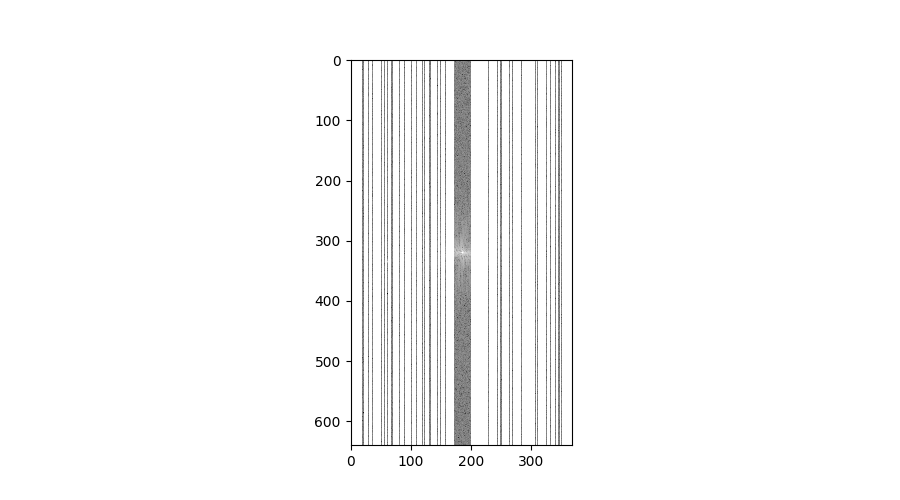

/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [9]:
plt.figure()
plt.imshow(np.log(np.abs(val_gen_k[0][0][0][15, ..., 0])))

48


<IPython.core.display.Javascript object>


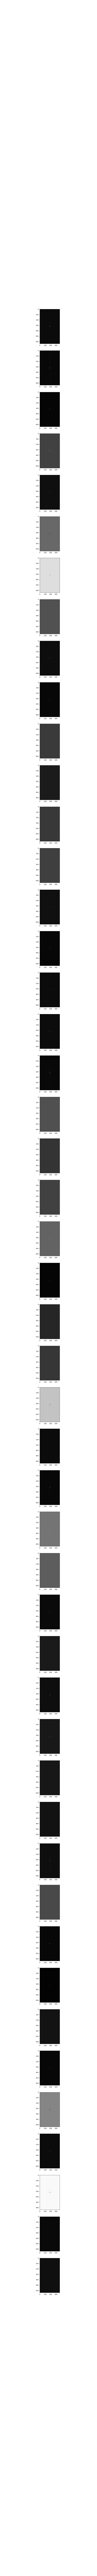

In [10]:
unique_non_nuls = np.unique(np.where(res[15] != 0)[2])
n_non_nuls = len(unique_non_nuls)
print(n_non_nuls)
fig, axs = plt.subplots(n_non_nuls, figsize=(9, 5*n_non_nuls))
for i, ax in zip(unique_non_nuls, axs):
#     ax.imshow(np.log(np.squeeze(res[15, ..., i])))
    ax.imshow(np.squeeze(res[15, ..., i]))

In [11]:
n_res = res.shape[-1]
print(n_res)

48


In [12]:
# fig, axs = plt.subplots(n_res, figsize=(9, 5*n_res))
# for i, ax in enumerate(axs):
#     ax.imshow(np.squeeze(res[15, ..., i]))